IMPORT

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.metrics import BinaryAccuracy, AUC
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.activations import sigmoid, softmax
from tensorflow.keras import preprocessing
from tensorflow.keras import backend
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#import tensorflow_addons as tfa
import random
import math

STANDARD VALUES

In [2]:
IMAGE_SIZE = 320
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 6
IMAGES = 50000
TRAIN_VALIDATION_SPLIT = 0.8
IMAGE_AUGMENTATION = True
ACTIVATION =  sigmoid
INITIALIZER = GlorotUniform(seed = 42)
FEATURES = "Path"
LABELS = ["Pneumonia", "Edema", "Fracture", "No Finding", "Cardiomegaly"]
METRICS = ["binary_accuracy", "accuracy", AUC(name = "auc", multi_label = True)]

FUNCTIONS

In [3]:
def parse_image(features, label):
    image_string = tf.io.read_file(features)
    image = tf.image.decode_jpeg(image_string, channels = CHANNELS)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0
    
    return image, label

def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe[FEATURES].values, dataframe[LABELS].values))
    dataset = dataset.map(parse_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    return dataset

def preprocess_dataset(dataset, is_training):
    dataset = dataset.cache().shuffle(10, reshuffle_each_iteration = False)
    
    if is_training == True and IMAGE_AUGMENTATION == True:
        print("Images in training dataset before augmentation: " + str(len(dataset)))
        dataset_augmented = dataset.take(int(0.5*IMAGES*TRAIN_VALIDATION_SPLIT)).map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.concatenate(dataset_augmented)
        print("Images in training dataset after augmentation: " + str(len(dataset)))

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)
    
    return dataset

def augment(image, label):
    #image = tfa.image.rotate(image, random.uniform(-10, 10)*math.pi/180)
    image = tf.image.central_crop(image, random.uniform(0.9, 1.0))
    image = tf.image.random_brightness(image, max_delta = 0.1)
    image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    return image, label

def plot_training(history):
    history_dict = history.history
    history_dict = list(history_dict)[:int(len(history_dict)/2)]
    
    plt.style.use("seaborn")
    plt.figure(figsize = (13, 10))
    num_rows = math.ceil(len(history_dict)/2)
    num_cols = 2
    pos = 1
    
    for h in history_dict:
        plt.subplot(num_rows, num_cols, pos)
        plt.plot(history.history[h])
        plt.plot(history.history["val_" + h])
        plt.title("model " + h, fontweight = "bold", fontsize = 13)
        plt.ylabel(h)
        plt.xlabel("epochs")
        plt.legend(["train", "valid"], loc = "best") 
        pos += 1
        
def plot_roc_curve(training):
    if training == True:
        dataset = train_ds
        pred = pred_train
        training_str = "training"
        pos = 1
    else:
        dataset = valid_ds
        pred = pred_valid
        training_str = "validation"
        pos = 2
    
    b = np.concatenate([b for a, b in dataset], axis = 0)
    auc_sum = 0.0
    
    for l in range(len(LABELS)):
        fpr, tpr, thresholds = roc_curve(b[:,l], pred[:,l])
        auc_metric = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = LABELS[l] + " (AUC: " + str(round(auc_metric, 4)) + ")")
        auc_sum += auc_metric
        
    plt.title("model ROC curve (" + training_str + ")", fontweight = "bold", fontsize = 13)
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    plt.legend(loc = "best")
    
    auc_average = auc_sum/len(LABELS)
    print("Average AUC " + "(" + training_str + "): " + str(auc_average))
    
def plot_roc_curves():
    plt.style.use("seaborn")
    
    plt.figure(figsize = (13, 5))
    num_rows = 1
    num_cols = 2
    
    plt.subplot(num_rows, num_cols, 1)
    plot_roc_curve(training = True)
    
    plt.subplot(num_rows, num_cols, 2)
    plot_roc_curve(training = False)

def show_examples(training, number):
    number = min(number, 10)
    
    if training == True:
        dataset = train_ds
        pred = pred_train
    else:
        dataset = valid_ds
        pred = pred_valid
    
    plt.style.use("seaborn")
    num_rows = 1
    num_cols = 2
    pos = 1
    label_pred_str = ""
    
    for num in range(number):    
        
        print("\033[1m" + "Image " + str(num + 1) + ":\t" + "\033[0m")
        
        for l in range(len(LABELS)):
            
            index = random.randint(0, len(dataset))
            a, b = list(dataset.unbatch())[index]
            
            if(b[l] == 1.0):
            
                label_pred_str += str(LABELS[l] + ": ")
                label_pred_str += str(round(pred[index][l]*100, 2)) + " "
            
            print(LABELS[l])
            print(str(b.numpy()[l]) + "\t(Prediction: " + str(round(pred[index][l]*100, 2)) + "%)")
        
        fig = plt.figure(figsize = (13, 7))
        
        plt.subplot(num_rows, num_cols, pos)
        plt.imshow((a.numpy()*255).astype("uint8"))
        plt.grid(None)
        plt.title("Image " + str(num + 1), fontweight = "bold", fontsize = 13)
        plt.xlabel(label_pred_str)
        
        pos += 1
        
        plt.subplot(num_rows, num_cols, pos)
        plt.imshow(heatmap(a.numpy()))
        plt.grid(None)
        plt.title("Heatmap image " + str(num + 1), fontweight = "bold", fontsize = 13)
        
        pos = 1
        
        plt.show()
        label_pred_str = ""
        
            
def heatmap(image_tensor):
    conv_layer = model.get_layer(name = "last_conv_layer")
    image_tensor = np.expand_dims(image_tensor, axis = 0)
    image_tensor = tf.cast(image_tensor, dtype = tf.float32)
    
    heatmap_model = Model([model.inputs], [conv_layer.output, model.output])
    
    with tf.GradientTape() as gtape:
        conv_output, predictions = heatmap_model(image_tensor)
        loss = predictions[:, np.argmax(predictions[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = backend.mean(grads, axis = (0, 1, 2))
        
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis = -1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    hm = np.squeeze(heatmap)
    
    return hm

TRAIN & VALIDATION DATA FRAME

In [4]:
dataframe = pd.read_csv("Chexpert/train.csv")

for l in LABELS:
    dataframe[l][dataframe[l] < 0] = 0
    dataframe[l] = dataframe[l].fillna(0)

dataframe = dataframe[dataframe["Frontal/Lateral"] != "Lateral"][:IMAGES]

dataframe["Patient"] = dataframe.Path.str.split('/',3,True)[2].str.split("patient", 2, True)[1] 
dataframe["Patient"] = [i.lstrip("0") for i in dataframe["Patient"]]

dataframe["Study"] = dataframe.Path.str.split('/',4,True)[3].str.split("study", 2, True)[1]
    
dataframe.head()

/scratch/slurm_tmpdir/job_20544400/ipykernel_4138162/741237622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[l][dataframe[l] < 0] = 0


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient,Study
0,Chexpert/train/patient00001/study1/view1_front...,Female,68,Frontal,AP,1.0,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,1.0,1,1
1,Chexpert/train/patient00002/study2/view1_front...,Female,87,Frontal,AP,0.0,NaN,0.0,1.0,NaN,...,-1.0,0.0,-1.0,NaN,-1.0,NaN,1.0,NaN,2,2
2,Chexpert/train/patient00002/study1/view1_front...,Female,83,Frontal,AP,0.0,NaN,0.0,1.0,NaN,...,-1.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,2,1
4,Chexpert/train/patient00003/study1/view1_front...,Male,41,Frontal,AP,0.0,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,3,1
5,Chexpert/train/patient00004/study1/view1_front...,Female,20,Frontal,PA,1.0,0.0,0.0,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,4,1


In [5]:
dataframe.shape

(50000, 21)

TEST DATA FRAME

In [6]:
dataframe_test = pd.read_csv("Chexpert/valid.csv")

dataframe_test = dataframe_test[dataframe_test["Frontal/Lateral"] != "Lateral"]

dataframe_test.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,Chexpert/valid/patient64541/study1/view1_front...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Chexpert/valid/patient64542/study1/view1_front...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,Chexpert/valid/patient64543/study1/view1_front...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Chexpert/valid/patient64544/study1/view1_front...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Chexpert/valid/patient64545/study1/view1_front...,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [7]:
dataframe_test.shape

(202, 19)

CREATE TRAIN & VALIDATION DATASET

In [8]:
dataset = create_dataset(dataframe)

2022-03-20 20:55:23.316318: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-20 20:55:33.792818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30979 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-03-20 20:55:33.816347: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30979 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0
2022-03-20 20:55:33.817946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

SPLIT TRAIN & VALIDATION DATASET

In [9]:
train_ds = dataset.take(int(TRAIN_VALIDATION_SPLIT*IMAGES))
valid_ds = dataset.skip(int(TRAIN_VALIDATION_SPLIT*IMAGES))

train_ds = preprocess_dataset(train_ds, True)
valid_ds = preprocess_dataset(valid_ds, False)

Images in training dataset before augmentation: 40000
Images in training dataset after augmentation: 60000


CREATE TEST DATASET

In [10]:
test_ds = create_dataset(dataframe_test)
test_ds = preprocess_dataset(test_ds, False)

MODEL

In [11]:
base_model = DenseNet121(
    include_top = False, 
    weights = "imagenet", 
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling = None, 
)

base_model.trainable = False

inputs = tf.keras.Input(shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = base_model(inputs, training = False)
x = tf.keras.layers.Conv2D(32, (3, 3), name = "last_conv_layer")(x)
x = tf.keras.layers.GlobalAveragePooling2D(name = "last_pooling_layer")(x)

outputs = tf.keras.layers.Dense(
    len(LABELS),
    kernel_initializer = INITIALIZER,
    activation = ACTIVATION
)(x) 

model = tf.keras.Model(inputs, outputs)

model.compile(
    loss = "binary_crossentropy",
    optimizer = "adam",
    metrics = METRICS
)

#model.summary(expand_nested = True) 

TRAINING

In [12]:
history = model.fit(train_ds, epochs = EPOCHS, validation_data = valid_ds)

Epoch 1/6


2022-03-20 20:55:53.450570: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


3749/3750 [============================>.] - ETA: 0s - loss: 0.3491 - binary_accuracy: 0.8831 - accuracy: 0.2678 - auc: 0.6445

2022-03-20 21:00:02.555909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10
2022-03-20 21:00:02.562866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 10
2022-03-20 21:00:02.562908: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 10
2022-03-20 21:00:02.562970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


3750/3750 [==============================] - 294s 66ms/step - loss: 0.3490 - binary_accuracy: 0.8831 - accuracy: 0.2678 - auc: 0.6445 - val_loss: 0.2707 - val_binary_accuracy: 0.8986 - val_accuracy: 0.2654 - val_auc: 0.7192
Epoch 2/6
3750/3750 [==============================] - 171s 45ms/step - loss: 0.2791 - binary_accuracy: 0.8933 - accuracy: 0.2905 - auc: 0.6928 - val_loss: 0.2675 - val_binary_accuracy: 0.8995 - val_accuracy: 0.2903 - val_auc: 0.7246
Epoch 3/6
3750/3750 [==============================] - 168s 45ms/step - loss: 0.2768 - binary_accuracy: 0.8938 - accuracy: 0.2910 - auc: 0.7043 - val_loss: 0.2693 - val_binary_accuracy: 0.8998 - val_accuracy: 0.2864 - val_auc: 0.7251
Epoch 4/6
3750/3750 [==============================] - 166s 44ms/step - loss: 0.2740 - binary_accuracy: 0.8946 - accuracy: 0.2932 - auc: 0.7166 - val_loss: 0.2718 - val_binary_accuracy: 0.8986 - val_accuracy: 0.2801 - val_auc: 0.7225
Epoch 5/6
3750/3750 [==============================] - 167s 45ms/step - lo

MODEL EVALUATION ON TEST DATASET

In [13]:
model.evaluate(test_ds)

13/13 [==============================] - 3s 233ms/step - loss: 0.3016 - binary_accuracy: 0.8703 - accuracy: 0.3020 - auc: 0.6180


[0.30158549547195435,
 0.8702970743179321,
 0.301980197429657,
 0.6179608106613159]

MODEL PREDICTIONS

In [14]:
pred_train = model.predict(train_ds)
pred_valid = model.predict(valid_ds)

MODEL TRAINING PLOTS

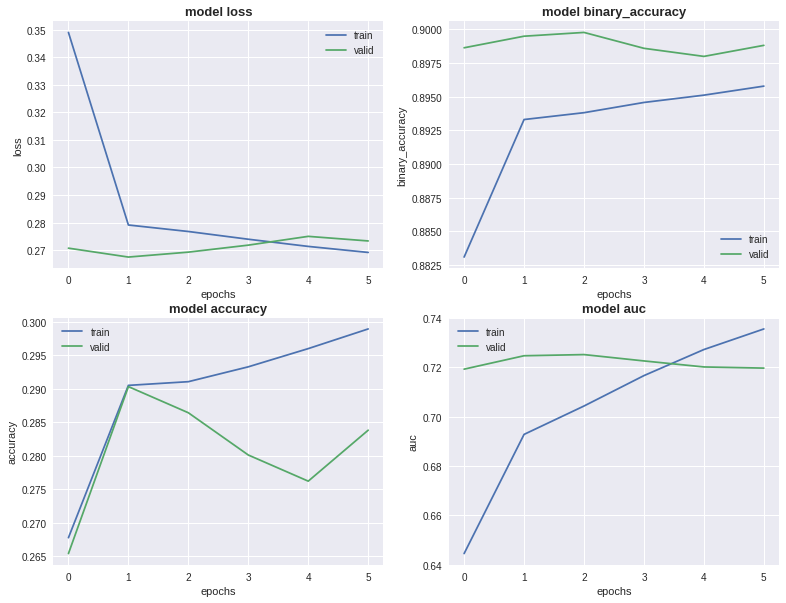

In [15]:
plot_training(history)

PLOT ROC CURVES

Average AUC (training): 0.7628329180232039
Average AUC (validation): 0.7323450102814756


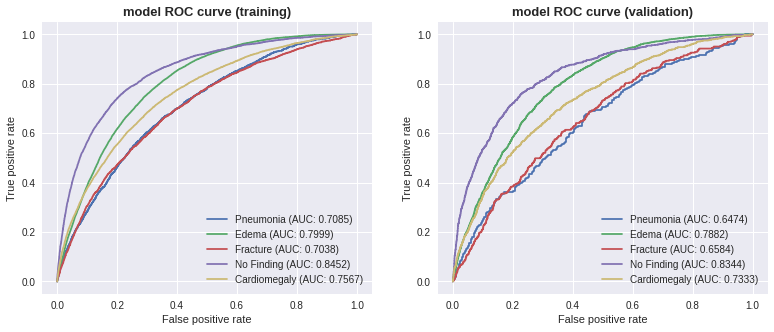

In [16]:
plot_roc_curves()

Image 1:	
Pneumonia
0.0	(Prediction: 0.37%)
Edema
0.0	(Prediction: 32.4%)
Fracture
0.0	(Prediction: 0.95%)
No Finding
0.0	(Prediction: 1.74%)
Cardiomegaly
0.0	(Prediction: 6.89%)


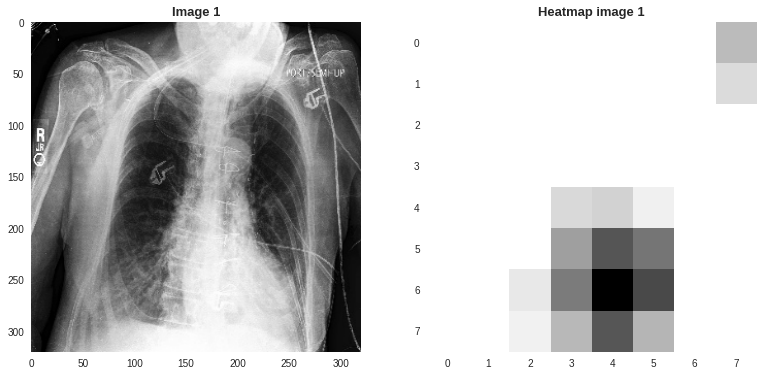

Image 2:	
Pneumonia
0.0	(Prediction: 1.92%)
Edema
1.0	(Prediction: 69.8%)
Fracture
0.0	(Prediction: 0.27%)
No Finding
0.0	(Prediction: 2.91%)
Cardiomegaly
1.0	(Prediction: 76.59%)


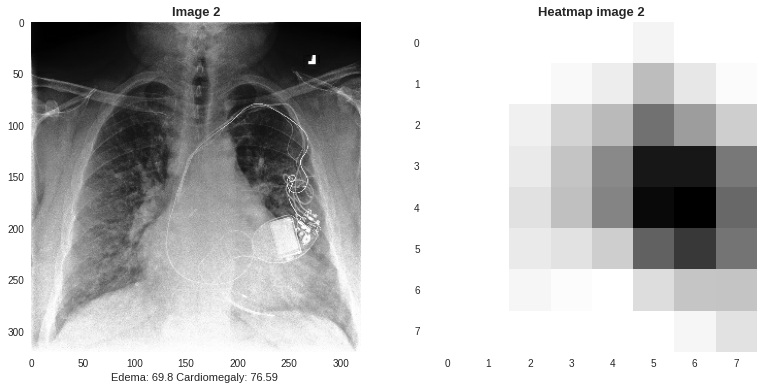

Image 3:	
Pneumonia
0.0	(Prediction: 2.67%)
Edema
1.0	(Prediction: 5.27%)
Fracture
0.0	(Prediction: 0.82%)
No Finding
0.0	(Prediction: 19.7%)
Cardiomegaly
0.0	(Prediction: 1.81%)


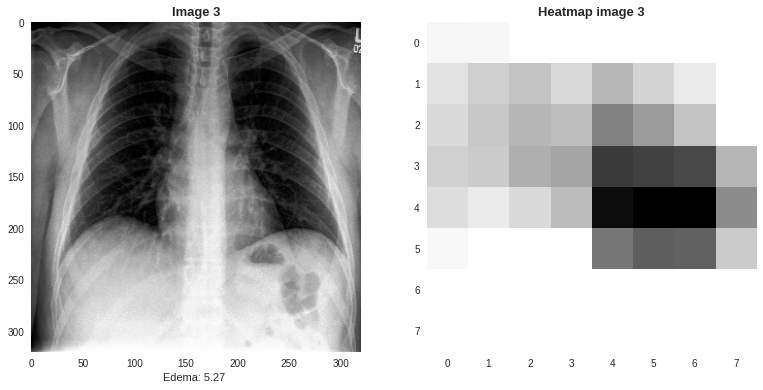

In [17]:
show_examples(training = True, number = 3)